In [1]:
import pandas as pd
import numpy as np
import ast

import os
import matplotlib.pyplot as plt
import seaborn as sns
from plinder_analysis_utils import DockingAnalysisBase, PoseBustersAnalysis, PropertyAnalysis

import statsmodels.formula.api as smf


In [2]:
PLINDER_TEST_COLUMNS = [
    "system_id", "ligand_smiles",
    # binary 
    # "ligand_is_covalent", "ligand_is_ion", "ligand_is_cofactor", "ligand_is_artifact",
    # discrete
    "system_num_protein_chains",
    "ligand_num_rot_bonds", "ligand_num_hbd", "ligand_num_hba", "ligand_num_rings",
    # continuous
    "entry_resolution", "entry_validation_molprobity", 
    "system_num_pocket_residues", "system_num_interactions",
    "ligand_molecular_weight", "ligand_crippen_clogp", 
    "ligand_num_interacting_residues", "ligand_num_neighboring_residues", "ligand_num_interactions",
]
# Create category mapping for visualization
CATEGORY_MAPPING = {
    "ligand_is_covalent": "binary",
    "ligand_is_ion": "binary",
    "ligand_is_cofactor": "binary",
    "ligand_is_artifact": "binary",
    "system_num_protein_chains": "discrete",
    "ligand_num_rot_bonds": "continuous",    
    "ligand_num_hbd": "continuous",
    "ligand_num_hba": "continuous",
    "ligand_num_rings": "continuous",
    "entry_resolution": "continuous",
    "entry_validation_molprobity": "continuous",
    "system_num_pocket_residues": "continuous",
    "system_num_interactions": "continuous",
    "ligand_molecular_weight": "continuous",
    "ligand_crippen_clogp": "continuous",
    "ligand_num_interacting_residues": "continuous",
    "ligand_num_neighboring_residues": "continuous",
    "ligand_num_interactions": "continuous",
    "ligand_is_artifact": "binary"     
}

In [3]:
df_combined = pd.read_csv("plinder_set_0_annotated.csv")

/var/folders/bb/dyy85zps4_lg79d6g6g48ms00000gn/T/ipykernel_46722/2737273468.py:1: DtypeWarning: Columns (78) have mixed types. Specify dtype option on import or set low_memory=False.
  df_combined = pd.read_csv("plinder_set_0_annotated.csv")


In [4]:
# build a boolean mask: drop any row where covalent, ionic or has_ion is True
mask = ~(
    df_combined['ligand_is_covalent'] |
    df_combined['ligand_is_ion'] |
    df_combined['has_ion'] |
    df_combined['ligand_is_cofactor']
)

# filter and reset index
df_combined = df_combined.loc[mask].reset_index(drop=True)
print("Filtered shape:", df_combined.shape)

Filtered shape: (14961, 154)


In [5]:
# First analyze multiple properties
property_analysis = PropertyAnalysis(df_combined)
methods = ["surfdock", "gnina", "chai-1", "diffdock_pocket_only", "icm", "vina"]

# Comparative Between Physics-based and ML-based: Mixed Effect Analysi

## Prepare the df

In [28]:
MIXED_EFFECT_VARS = [
    "protein", "rmsd","method",
    # "system_id", "ligand_smiles",
    # binary 
    # "ligand_is_covalent", "ligand_is_ion", "ligand_is_cofactor", "ligand_is_artifact",
    # discrete
    # "system_num_protein_chains",
    "ligand_num_rot_bonds", "ligand_num_hbd", "ligand_num_hba", "ligand_num_rings",
    # continuous
    "entry_resolution", "entry_validation_molprobity", 
    # "system_num_pocket_residues", 
    "system_num_interactions",
    "ligand_molecular_weight", "ligand_crippen_clogp", 
    "ligand_num_interacting_residues", 
    "ligand_num_neighboring_residues", 
    "ligand_num_interactions",
]

In [29]:
df_mixed = df_combined[MIXED_EFFECT_VARS]
# Create a Method_Type column based on the classification
df_mixed['Method_Type'] = df_mixed['method'].apply(
    lambda x: 'ML' if x in ['chai-1', 'diffdock_pocket_only', 'surfdock'] else 'Physics'
)

# Display the counts of each method type
print(df_mixed['Method_Type'].value_counts())

# Verify the classification
for method in df_mixed['method'].unique():
    method_type = 'ML' if method in ['chai-1', 'diffdock_pocket_only', 'surfdock'] else 'Physics'
    print(f"{method}: {method_type}")

Method_Type
ML         7616
Physics    7345
Name: count, dtype: int64
diffdock_pocket_only: ML
gnina: Physics
surfdock: ML
icm: Physics
chai-1: ML
vina: Physics


/var/folders/bb/dyy85zps4_lg79d6g6g48ms00000gn/T/ipykernel_46722/953947549.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mixed['Method_Type'] = df_mixed['method'].apply(


## Mixed_Effect Analysis

### system_num_protein_chains

In [8]:
property = "ligand_num_rot_bonds"
df_method = (
    df_mixed[[
        "rmsd",
        property,
        "Method_Type",
        "protein"       # or "system_id", whichever you’re grouping by
    ]]
    .dropna()
    .reset_index(drop=True)    # <<-- important!
)
print(df_method.shape)

model = smf.mixedlm(
    f"rmsd ~ {property} * Method_Type",
    data=df_method,
    groups=df_method["protein"]
).fit()

print(model.summary())

(12163, 4)
                        Mixed Linear Model Regression Results
Model:                       MixedLM          Dependent Variable:          rmsd       
No. Observations:            12163            Method:                      REML       
No. Groups:                  462              Scale:                       117.5639   
Min. group size:             5                Log-Likelihood:              -46651.8153
Max. group size:             35               Converged:                   Yes        
Mean group size:             26.3                                                     
--------------------------------------------------------------------------------------
                                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------
Intercept                                    6.599    0.440 14.997 0.000  5.737  7.462
Method_Type[T.Physics]                      -1.770    0.3

### ligand_num_rot_bonds

In [9]:
property = "ligand_num_rot_bonds"
df_method = (
    df_mixed[[
        "rmsd",
        property,
        "Method_Type",
        "protein"       # or "system_id", whichever you’re grouping by
    ]]
    .dropna()
    .reset_index(drop=True)    # <<-- important!
)
print(df_method.shape)

property_analysis.analyze_comparative_fixed_effects(df_method, property, "Method_Type", "rmsd", "protein")

(12163, 4)
                        Mixed Linear Model Regression Results
Model:                       MixedLM          Dependent Variable:          rmsd       
No. Observations:            12163            Method:                      REML       
No. Groups:                  462              Scale:                       117.5639   
Min. group size:             5                Log-Likelihood:              -46651.8153
Max. group size:             35               Converged:                   Yes        
Mean group size:             26.3                                                     
--------------------------------------------------------------------------------------
                                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------
Intercept                                    6.599    0.440 14.997 0.000  5.737  7.462
Method_Type[T.Physics]                      -1.770    0.3

/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/plinder_analysis_utils.py:4188: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(


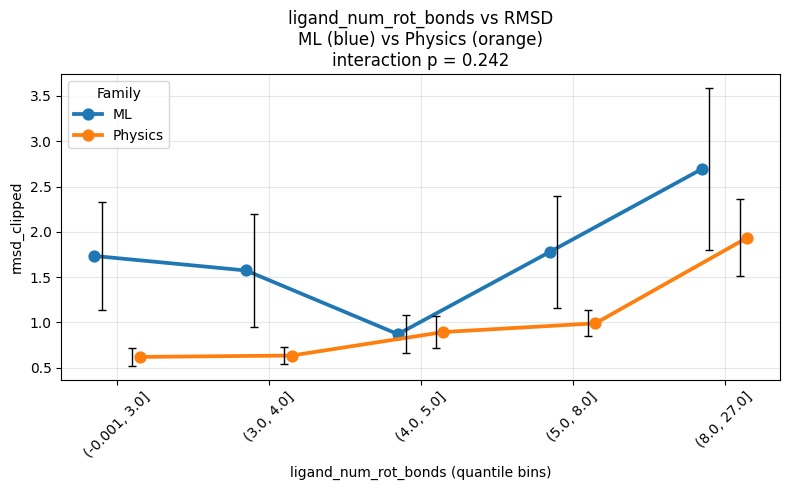

0.24203545762182782
                                               Mixed Linear Model Regression Results
Model:                                     MixedLM                         Dependent Variable:                         rmsd_clipped
No. Observations:                          919                             Method:                                     REML        
No. Groups:                                462                             Scale:                                      4.8691      
Min. group size:                           1                               Log-Likelihood:                             -2097.5425  
Max. group size:                           2                               Converged:                                  Yes         
Mean group size:                           2.0                                                                                     
-------------------------------------------------------------------------------------------------------

In [10]:
results = property_analysis.analyze_continous_property_mixed_effects(
    df_combined[df_combined["method"].isin(["chai-1", "diffdock_pocket_only", "surfdock"])],
    df_combined[df_combined["method"].isin(["icm", "gnina", "vina"])],
    property_name=property, 
    group1_label="ML",
    group2_label="Physics",
)
print(results['p_interaction'])
print(results['model_full'].summary())
print(results['model_noint'].summary())


#### without gnina

/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/plinder_analysis_utils.py:4188: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(


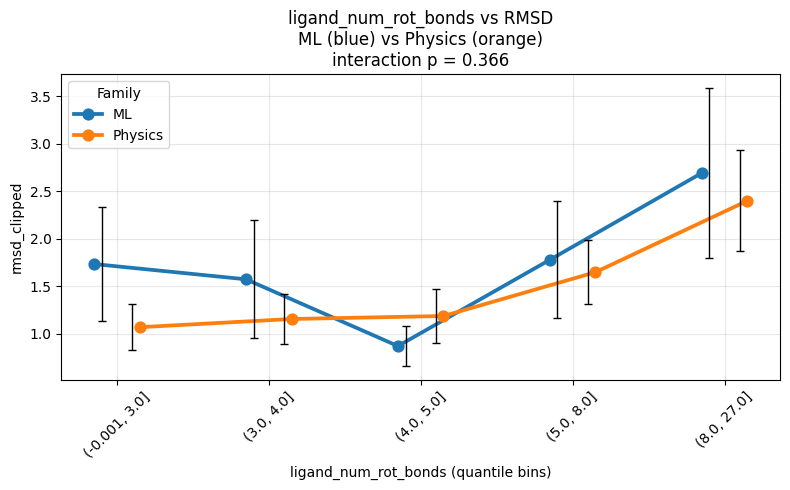

0.36596396617105215
                                               Mixed Linear Model Regression Results
Model:                                     MixedLM                         Dependent Variable:                         rmsd_clipped
No. Observations:                          910                             Method:                                     REML        
No. Groups:                                462                             Scale:                                      5.7452      
Min. group size:                           1                               Log-Likelihood:                             -2144.0178  
Max. group size:                           2                               Converged:                                  Yes         
Mean group size:                           2.0                                                                                     
-------------------------------------------------------------------------------------------------------

In [11]:
results = property_analysis.analyze_continous_property_mixed_effects(
    df_combined[df_combined["method"].isin(["chai-1", "diffdock_pocket_only", "surfdock"])],
    df_combined[df_combined["method"].isin(["icm", "vina"])],
    property_name=property, 
    group1_label="ML",
    group2_label="Physics",
)
print(results['p_interaction'])
print(results['model_full'].summary())
print(results['model_noint'].summary())

### ligand_num_hbd

(12153, 4)
                     Mixed Linear Model Regression Results
Model:                     MixedLM        Dependent Variable:        rmsd       
No. Observations:          12153          Method:                    REML       
No. Groups:                460            Scale:                     117.8488   
Min. group size:           10             Log-Likelihood:            -46629.0400
Max. group size:           35             Converged:                 Yes        
Mean group size:           26.4                                                 
--------------------------------------------------------------------------------
                                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------
Intercept                              6.033    0.441 13.670 0.000  5.168  6.898
Method_Type[T.Physics]                -0.312    0.341 -0.915 0.360 -0.980  0.356
ligand_num_hbd                         

/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/plinder_analysis_utils.py:4188: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(


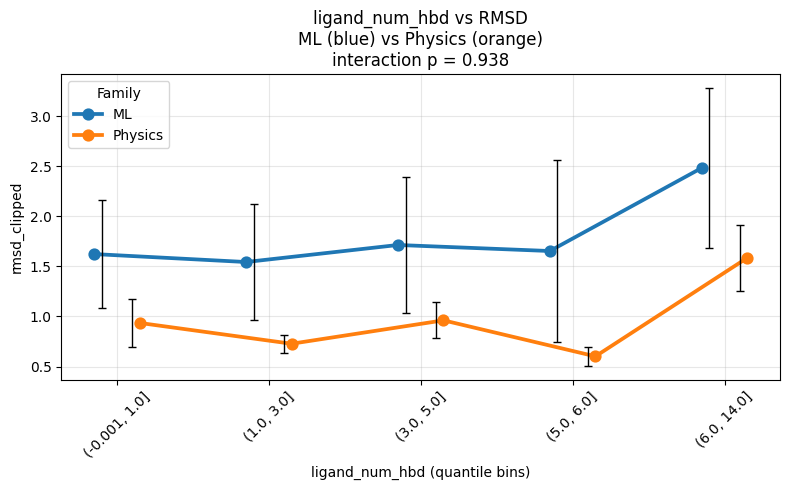

0.9379990207533656
                                            Mixed Linear Model Regression Results
Model:                                   MixedLM                       Dependent Variable:                       rmsd_clipped
No. Observations:                        917                           Method:                                   REML        
No. Groups:                              460                           Scale:                                    4.9284      
Min. group size:                         1                             Log-Likelihood:                           -2103.3603  
Max. group size:                         2                             Converged:                                Yes         
Mean group size:                         2.0                                                                                 
-----------------------------------------------------------------------------------------------------------------------------
                 

In [12]:
property = "ligand_num_hbd"
df_method = (
    df_mixed[[
        "rmsd",
        property,
        "Method_Type",
        "protein"       # or "system_id", whichever you’re grouping by
    ]]
    .dropna()
    .reset_index(drop=True)    # <<-- important!
)
print(df_method.shape)

property_analysis.analyze_comparative_fixed_effects(df_method, property, "Method_Type", "rmsd", "protein")

results = property_analysis.analyze_continous_property_mixed_effects(
    df_combined[df_combined["method"].isin(["chai-1", "diffdock_pocket_only", "surfdock"])],
    df_combined[df_combined["method"].isin(["icm", "gnina", "vina"])],
    property_name=property, 
    group1_label="ML",
    group2_label="Physics",
)
print(results['p_interaction'])
print(results['model_full'].summary())
print(results['model_noint'].summary())


#### without gnina

/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/plinder_analysis_utils.py:4188: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(


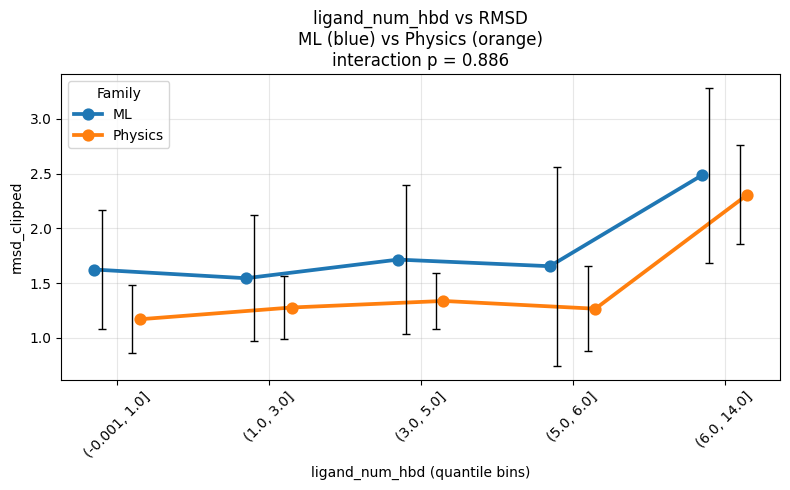

0.8860161477718775
                                            Mixed Linear Model Regression Results
Model:                                   MixedLM                       Dependent Variable:                       rmsd_clipped
No. Observations:                        907                           Method:                                   REML        
No. Groups:                              460                           Scale:                                    5.7824      
Min. group size:                         1                             Log-Likelihood:                           -2143.6314  
Max. group size:                         2                             Converged:                                Yes         
Mean group size:                         2.0                                                                                 
-----------------------------------------------------------------------------------------------------------------------------
                 

In [13]:
results = property_analysis.analyze_continous_property_mixed_effects(
    df_combined[df_combined["method"].isin(["chai-1", "diffdock_pocket_only", "surfdock"])],
    df_combined[df_combined["method"].isin(["icm", "vina"])],
    property_name=property, 
    group1_label="ML",
    group2_label="Physics",
)
print(results['p_interaction'])
print(results['model_full'].summary())
print(results['model_noint'].summary())

### ligand_num_hba

(12153, 4)
                     Mixed Linear Model Regression Results
Model:                     MixedLM        Dependent Variable:        rmsd       
No. Observations:          12153          Method:                    REML       
No. Groups:                460            Scale:                     117.8299   
Min. group size:           10             Log-Likelihood:            -46629.6392
Max. group size:           35             Converged:                 Yes        
Mean group size:           26.4                                                 
--------------------------------------------------------------------------------
                                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------
Intercept                              6.290    0.552 11.395 0.000  5.208  7.372
Method_Type[T.Physics]                -0.816    0.428 -1.903 0.057 -1.655  0.024
ligand_num_hba                         

/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/plinder_analysis_utils.py:4188: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(


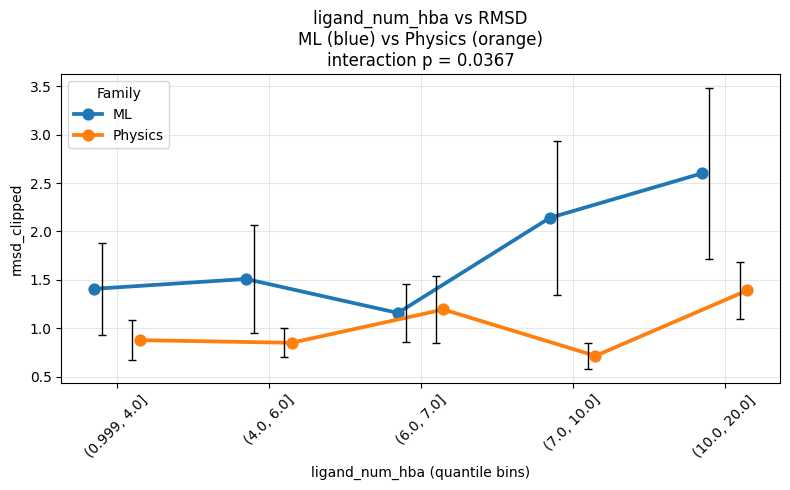

0.03668595242263716
                                            Mixed Linear Model Regression Results
Model:                                    MixedLM                       Dependent Variable:                       rmsd_clipped
No. Observations:                         917                           Method:                                   REML        
No. Groups:                               460                           Scale:                                    4.8286      
Min. group size:                          1                             Log-Likelihood:                           -2099.0947  
Max. group size:                          2                             Converged:                                Yes         
Mean group size:                          2.0                                                                                 
------------------------------------------------------------------------------------------------------------------------------
         

In [14]:
property = "ligand_num_hba"
df_method = (
    df_mixed[[
        "rmsd",
        property,
        "Method_Type",
        "protein"       # or "system_id", whichever you’re grouping by
    ]]
    .dropna()
    .reset_index(drop=True)    # <<-- important!
)
print(df_method.shape)

property_analysis.analyze_comparative_fixed_effects(df_method, property, "Method_Type", "rmsd", "protein")

results = property_analysis.analyze_continous_property_mixed_effects(
    df_combined[df_combined["method"].isin(["chai-1", "diffdock_pocket_only", "surfdock"])],
    df_combined[df_combined["method"].isin(["icm", "gnina", "vina"])],
    property_name=property, 
    group1_label="ML",
    group2_label="Physics",
)
print(results['p_interaction'])
print(results['model_full'].summary())
print(results['model_noint'].summary())


#### without gnina

/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/plinder_analysis_utils.py:4188: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(


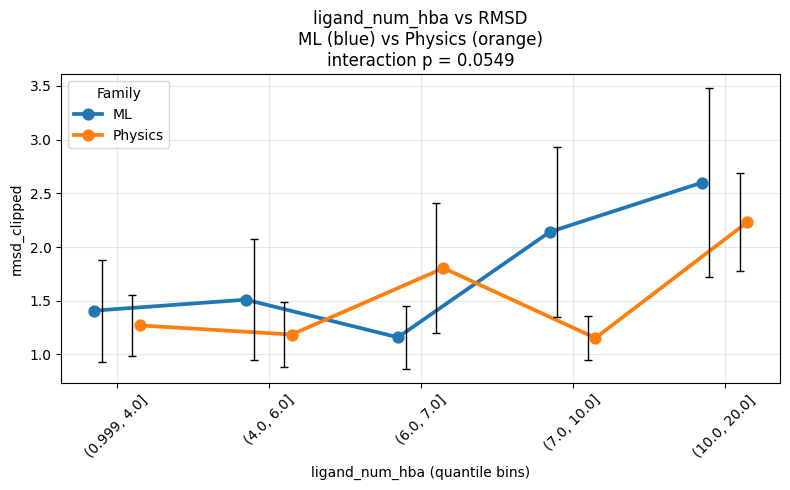

0.05494835596044596
                                            Mixed Linear Model Regression Results
Model:                                    MixedLM                       Dependent Variable:                       rmsd_clipped
No. Observations:                         907                           Method:                                   REML        
No. Groups:                               460                           Scale:                                    5.6667      
Min. group size:                          1                             Log-Likelihood:                           -2138.7057  
Max. group size:                          2                             Converged:                                Yes         
Mean group size:                          2.0                                                                                 
------------------------------------------------------------------------------------------------------------------------------
         

In [15]:
results = property_analysis.analyze_continous_property_mixed_effects(
    df_combined[df_combined["method"].isin(["chai-1", "diffdock_pocket_only", "surfdock"])],
    df_combined[df_combined["method"].isin(["icm", "vina"])],
    property_name=property, 
    group1_label="ML",
    group2_label="Physics",
)
print(results['p_interaction'])
print(results['model_full'].summary())
print(results['model_noint'].summary())

### ligand_num_rings

(12153, 4)
                      Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         rmsd       
No. Observations:          12153           Method:                     REML       
No. Groups:                460             Scale:                      117.7287   
Min. group size:           10              Log-Likelihood:             -46623.3948
Max. group size:           35              Converged:                  Yes        
Mean group size:           26.4                                                   
----------------------------------------------------------------------------------
                                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------
Intercept                                8.154    0.543 15.009 0.000  7.089  9.218
Method_Type[T.Physics]                  -1.451    0.423 -3.427 0.001 -2.280 -0.621
ligand_num_rings

/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/plinder_analysis_utils.py:4188: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(


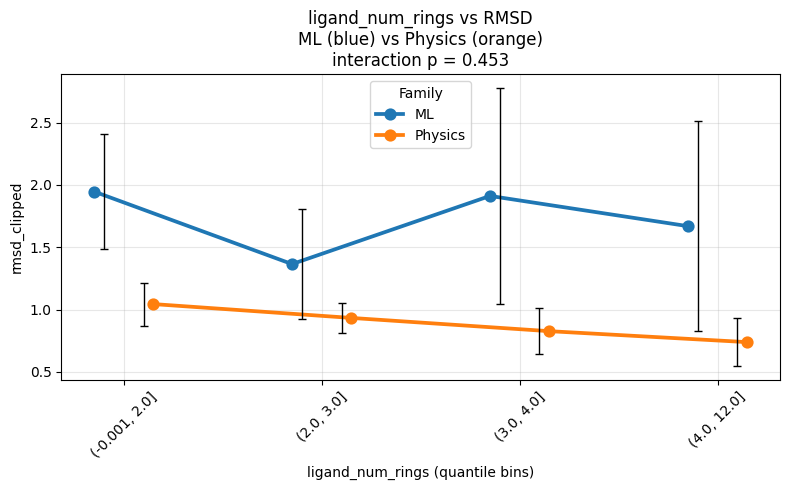

0.4526253378313415
                                             Mixed Linear Model Regression Results
Model:                                   MixedLM                        Dependent Variable:                        rmsd_clipped
No. Observations:                        917                            Method:                                    REML        
No. Groups:                              460                            Scale:                                     4.8988      
Min. group size:                         1                              Log-Likelihood:                            -2107.0485  
Max. group size:                         2                              Converged:                                 Yes         
Mean group size:                         2.0                                                                                   
-------------------------------------------------------------------------------------------------------------------------------
  

In [16]:
property = "ligand_num_rings"
df_method = (
    df_mixed[[
        "rmsd",
        property,
        "Method_Type",
        "protein"       # or "system_id", whichever you’re grouping by
    ]]
    .dropna()
    .reset_index(drop=True)    # <<-- important!
)
print(df_method.shape)

property_analysis.analyze_comparative_fixed_effects(df_method, property, "Method_Type", "rmsd", "protein")

results = property_analysis.analyze_continous_property_mixed_effects(
    df_combined[df_combined["method"].isin(["chai-1", "diffdock_pocket_only", "surfdock"])],
    df_combined[df_combined["method"].isin(["icm", "gnina", "vina"])],
    property_name=property, 
    group1_label="ML",
    group2_label="Physics",
)
print(results['p_interaction'])
print(results['model_full'].summary())
print(results['model_noint'].summary())


#### without gnina

/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/plinder_analysis_utils.py:4188: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(


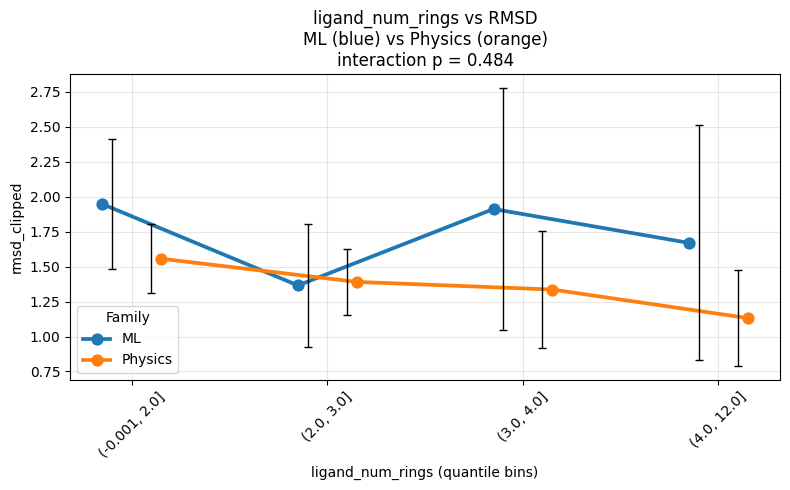

0.4840876716505592
                                             Mixed Linear Model Regression Results
Model:                                   MixedLM                        Dependent Variable:                        rmsd_clipped
No. Observations:                        907                            Method:                                    REML        
No. Groups:                              460                            Scale:                                     5.7097      
Min. group size:                         1                              Log-Likelihood:                            -2148.2919  
Max. group size:                         2                              Converged:                                 Yes         
Mean group size:                         2.0                                                                                   
-------------------------------------------------------------------------------------------------------------------------------
  

In [17]:
results = property_analysis.analyze_continous_property_mixed_effects(
    df_combined[df_combined["method"].isin(["chai-1", "diffdock_pocket_only", "surfdock"])],
    df_combined[df_combined["method"].isin(["icm", "vina"])],
    property_name=property, 
    group1_label="ML",
    group2_label="Physics",
)
print(results['p_interaction'])
print(results['model_full'].summary())
print(results['model_noint'].summary())

### entry_resolution

(12153, 4)
                      Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         rmsd       
No. Observations:          12153           Method:                     REML       
No. Groups:                460             Scale:                      117.0648   
Min. group size:           10              Log-Likelihood:             -46584.9104
Max. group size:           35              Converged:                  Yes        
Mean group size:           26.4                                                   
----------------------------------------------------------------------------------
                                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------
Intercept                                7.799    1.142  6.828 0.000  5.560 10.038
Method_Type[T.Physics]                  -8.007    0.897 -8.928 0.000 -9.765 -6.249
entry_resolution

/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/plinder_analysis_utils.py:4188: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(


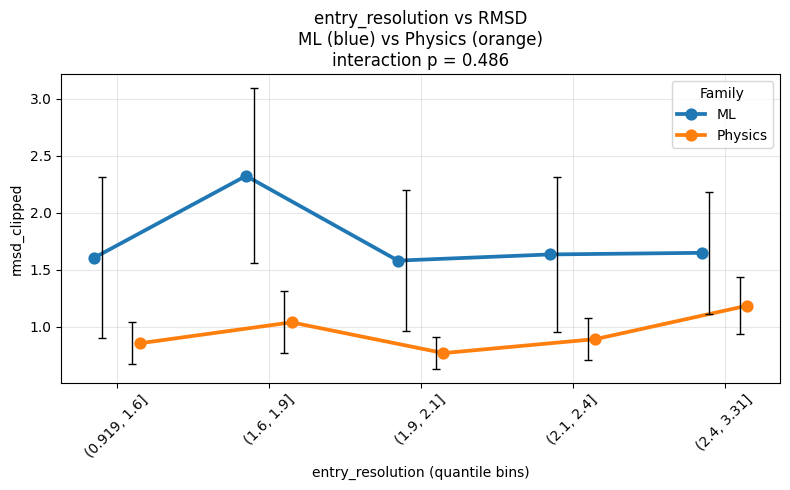

0.4857716924823998
                                             Mixed Linear Model Regression Results
Model:                                   MixedLM                        Dependent Variable:                        rmsd_clipped
No. Observations:                        917                            Method:                                    REML        
No. Groups:                              460                            Scale:                                     4.8997      
Min. group size:                         1                              Log-Likelihood:                            -2106.4269  
Max. group size:                         2                              Converged:                                 Yes         
Mean group size:                         2.0                                                                                   
-------------------------------------------------------------------------------------------------------------------------------
  

In [18]:
property = "entry_resolution"
df_method = (
    df_mixed[[
        "rmsd",
        property,
        "Method_Type",
        "protein"       # or "system_id", whichever you’re grouping by
    ]]
    .dropna()
    .reset_index(drop=True)    # <<-- important!
)
print(df_method.shape)

property_analysis.analyze_comparative_fixed_effects(df_method, property, "Method_Type", "rmsd", "protein")

results = property_analysis.analyze_continous_property_mixed_effects(
    df_combined[df_combined["method"].isin(["chai-1", "diffdock_pocket_only", "surfdock"])],
    df_combined[df_combined["method"].isin(["icm", "gnina", "vina"])],
    property_name=property, 
    group1_label="ML",
    group2_label="Physics",
)
print(results['p_interaction'])
print(results['model_full'].summary())
print(results['model_noint'].summary())


#### without gnina

/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/plinder_analysis_utils.py:4188: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(


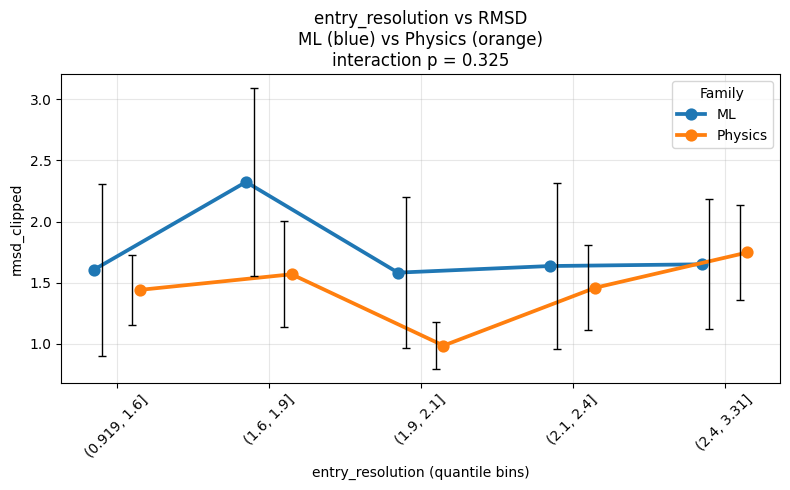

0.3250378113456363
                                             Mixed Linear Model Regression Results
Model:                                   MixedLM                        Dependent Variable:                        rmsd_clipped
No. Observations:                        907                            Method:                                    REML        
No. Groups:                              460                            Scale:                                     5.6969      
Min. group size:                         1                              Log-Likelihood:                            -2146.4928  
Max. group size:                         2                              Converged:                                 Yes         
Mean group size:                         2.0                                                                                   
-------------------------------------------------------------------------------------------------------------------------------
  

In [19]:
results = property_analysis.analyze_continous_property_mixed_effects(
    df_combined[df_combined["method"].isin(["chai-1", "diffdock_pocket_only", "surfdock"])],
    df_combined[df_combined["method"].isin(["icm", "vina"])],
    property_name=property, 
    group1_label="ML",
    group2_label="Physics",
)
print(results['p_interaction'])
print(results['model_full'].summary())
print(results['model_noint'].summary())

### entry_validation_molprobity

(12153, 4)
                            Mixed Linear Model Regression Results
Model:                        MixedLM             Dependent Variable:             rmsd       
No. Observations:             12153               Method:                         REML       
No. Groups:                   460                 Scale:                          117.8098   
Min. group size:              10                  Log-Likelihood:                 -46625.8004
Max. group size:              35                  Converged:                      Yes        
Mean group size:              26.4                                                           
---------------------------------------------------------------------------------------------
                                                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------------
Intercept                                           5.349    0.902  5.930 0.0

/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/plinder_analysis_utils.py:4188: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(


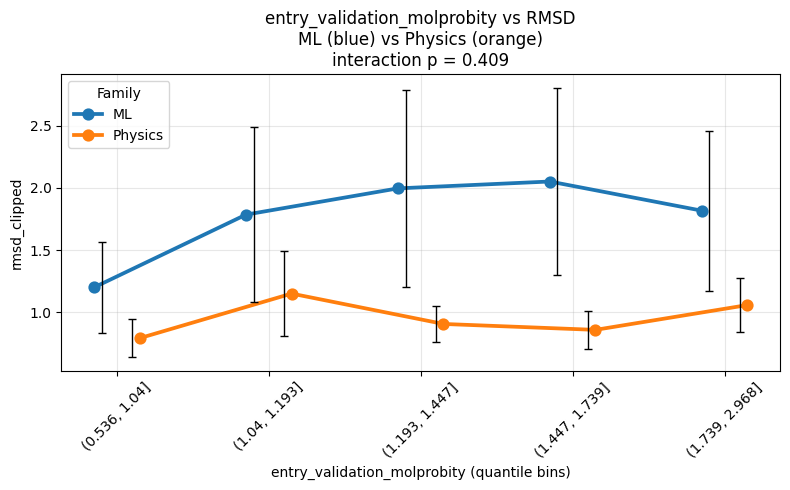

0.4093425027118073
                                                    Mixed Linear Model Regression Results
Model:                                         MixedLM                            Dependent Variable:                            rmsd_clipped
No. Observations:                              917                                Method:                                        REML        
No. Groups:                                    460                                Scale:                                         4.8926      
Min. group size:                               1                                  Log-Likelihood:                                -2106.2236  
Max. group size:                               2                                  Converged:                                     Yes         
Mean group size:                               2.0                                                                                           
---------------------------------------

In [20]:
property = "entry_validation_molprobity"
df_method = (
    df_mixed[[
        "rmsd",
        property,
        "Method_Type",
        "protein"       # or "system_id", whichever you’re grouping by
    ]]
    .dropna()
    .reset_index(drop=True)    # <<-- important!
)
print(df_method.shape)

property_analysis.analyze_comparative_fixed_effects(df_method, property, "Method_Type", "rmsd", "protein")

results = property_analysis.analyze_continous_property_mixed_effects(
    df_combined[df_combined["method"].isin(["chai-1", "diffdock_pocket_only", "surfdock"])],
    df_combined[df_combined["method"].isin(["icm", "gnina", "vina"])],
    property_name=property, 
    group1_label="ML",
    group2_label="Physics",
)
print(results['p_interaction'])
print(results['model_full'].summary())
print(results['model_noint'].summary())


#### without gnina

/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/plinder_analysis_utils.py:4188: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(


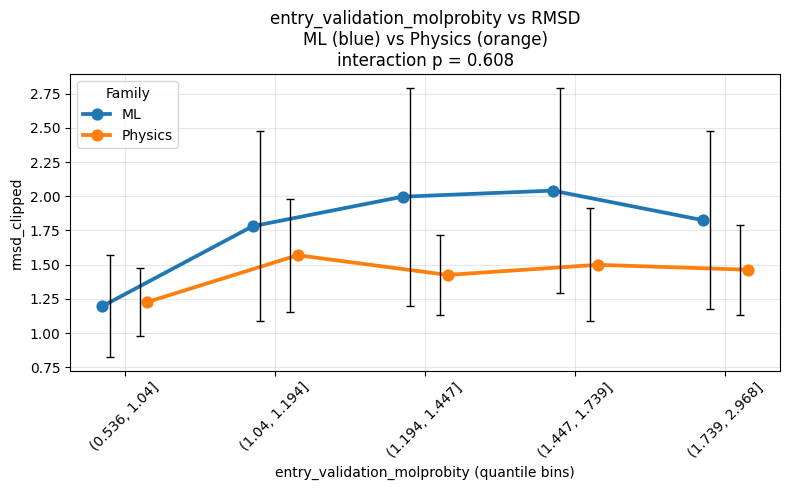

0.6083216001493785
                                                    Mixed Linear Model Regression Results
Model:                                         MixedLM                            Dependent Variable:                            rmsd_clipped
No. Observations:                              907                                Method:                                        REML        
No. Groups:                                    460                                Scale:                                         5.7191      
Min. group size:                               1                                  Log-Likelihood:                                -2148.0451  
Max. group size:                               2                                  Converged:                                     Yes         
Mean group size:                               2.0                                                                                           
---------------------------------------

In [21]:
results = property_analysis.analyze_continous_property_mixed_effects(
    df_combined[df_combined["method"].isin(["chai-1", "diffdock_pocket_only", "surfdock"])],
    df_combined[df_combined["method"].isin(["icm", "vina"])],
    property_name=property, 
    group1_label="ML",
    group2_label="Physics",
)
print(results['p_interaction'])
print(results['model_full'].summary())
print(results['model_noint'].summary())

### system_pocket_residues

### system_num_interactions

### ligand_molecular_weight

(12153, 4)
                          Mixed Linear Model Regression Results
Model:                        MixedLM           Dependent Variable:           rmsd       
No. Observations:             12153             Method:                       REML       
No. Groups:                   460               Scale:                        117.4701   
Min. group size:              10                Log-Likelihood:               -46616.8723
Max. group size:              35                Converged:                    Yes        
Mean group size:              26.4                                                       
-----------------------------------------------------------------------------------------
                                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------
Intercept                                       7.207    0.818  8.806 0.000  5.603  8.811
Method_Type[T.Physics]   

/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/plinder_analysis_utils.py:4188: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(


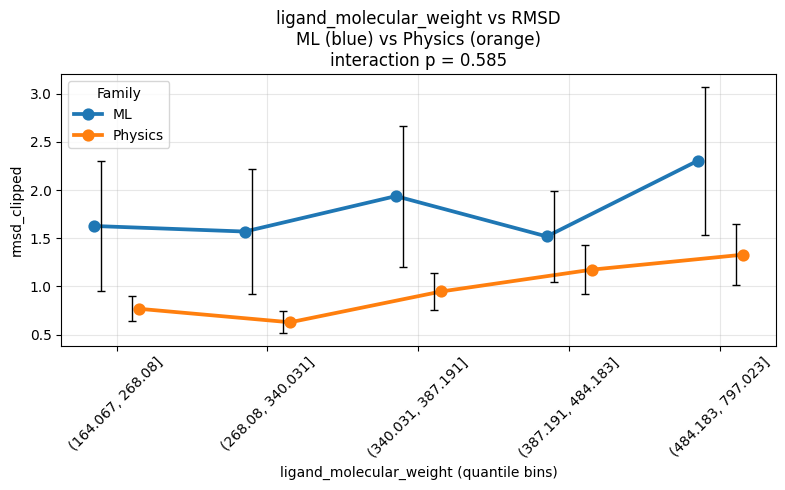

0.5850095188183392
                                                    Mixed Linear Model Regression Results
Model:                                         MixedLM                            Dependent Variable:                            rmsd_clipped
No. Observations:                              917                                Method:                                        REML        
No. Groups:                                    460                                Scale:                                         4.9059      
Min. group size:                               1                                  Log-Likelihood:                                -2104.6049  
Max. group size:                               2                                  Converged:                                     Yes         
Mean group size:                               2.0                                                                                           
---------------------------------------

In [22]:
property = "ligand_molecular_weight"
df_method = (
    df_mixed[[
        "rmsd",
        property,
        "Method_Type",
        "protein"       # or "system_id", whichever you’re grouping by
    ]]
    .dropna()
    .reset_index(drop=True)    # <<-- important!
)
print(df_method.shape)

property_analysis.analyze_comparative_fixed_effects(df_method, property, "Method_Type", "rmsd", "protein")

results = property_analysis.analyze_continous_property_mixed_effects(
    df_combined[df_combined["method"].isin(["chai-1", "diffdock_pocket_only", "surfdock"])],
    df_combined[df_combined["method"].isin(["icm", "gnina", "vina"])],
    property_name=property, 
    group1_label="ML",
    group2_label="Physics",
)
print(results['p_interaction'])
print(results['model_full'].summary())
print(results['model_noint'].summary())

#### without gnina

/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/plinder_analysis_utils.py:4188: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(


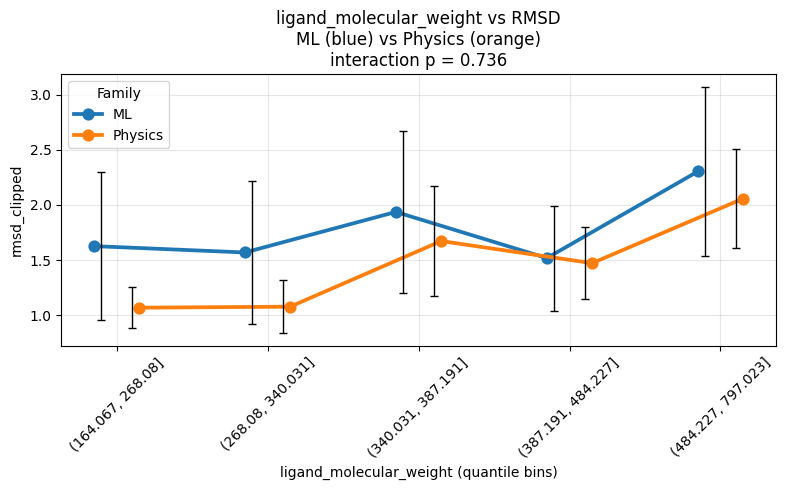

0.7362806416673983
                                                    Mixed Linear Model Regression Results
Model:                                         MixedLM                            Dependent Variable:                            rmsd_clipped
No. Observations:                              907                                Method:                                        REML        
No. Groups:                                    460                                Scale:                                         5.7780      
Min. group size:                               1                                  Log-Likelihood:                                -2144.6222  
Max. group size:                               2                                  Converged:                                     Yes         
Mean group size:                               2.0                                                                                           
---------------------------------------

In [23]:
results = property_analysis.analyze_continous_property_mixed_effects(
    df_combined[df_combined["method"].isin(["chai-1", "diffdock_pocket_only", "surfdock"])],
    df_combined[df_combined["method"].isin(["icm", "vina"])],
    property_name=property, 
    group1_label="ML",
    group2_label="Physics",
)
print(results['p_interaction'])
print(results['model_full'].summary())
print(results['model_noint'].summary())

### ligand_crippen_clogp

(12153, 4)
                        Mixed Linear Model Regression Results
Model:                       MixedLM          Dependent Variable:          rmsd       
No. Observations:            12153            Method:                      REML       
No. Groups:                  460              Scale:                       117.8211   
Min. group size:             10               Log-Likelihood:              -46630.1265
Max. group size:             35               Converged:                   Yes        
Mean group size:             26.4                                                     
--------------------------------------------------------------------------------------
                                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------
Intercept                                    6.811    0.259 26.260 0.000  6.303  7.320
Method_Type[T.Physics]                      -0.220    0.2

/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/plinder_analysis_utils.py:4188: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(


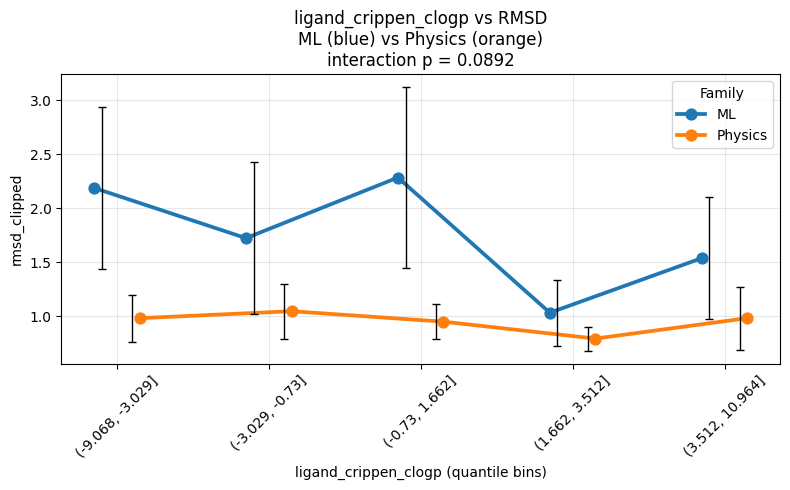

p_interaction: 0.08916640975982701
                                                 Mixed Linear Model Regression Results
Model:                                       MixedLM                          Dependent Variable:                          rmsd_clipped
No. Observations:                            917                              Method:                                      REML        
No. Groups:                                  460                              Scale:                                       4.8486      
Min. group size:                             1                                Log-Likelihood:                              -2102.0134  
Max. group size:                             2                                Converged:                                   Yes         
Mean group size:                             2.0                                                                                       
--------------------------------------------------------------

In [24]:
property = "ligand_crippen_clogp"
df_method = (
    df_mixed[[
        "rmsd",
        property,
        "Method_Type",
        "protein"       # or "system_id", whichever you’re grouping by
    ]]
    .dropna()
    .reset_index(drop=True)    # <<-- important!
)
print(df_method.shape)

property_analysis.analyze_comparative_fixed_effects(df_method, property, "Method_Type", "rmsd", "protein")

results = property_analysis.analyze_continous_property_mixed_effects(
    df_combined[df_combined["method"].isin(["chai-1", "diffdock_pocket_only", "surfdock"])],
    df_combined[df_combined["method"].isin(["icm", "gnina", "vina"])],
    property_name=property, 
    group1_label="ML",
    group2_label="Physics",
)
print(f"p_interaction: {results['p_interaction']}")
print(results['model_full'].summary())
print(results['model_noint'].summary())


#### without gnina

/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/plinder_analysis_utils.py:4188: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(


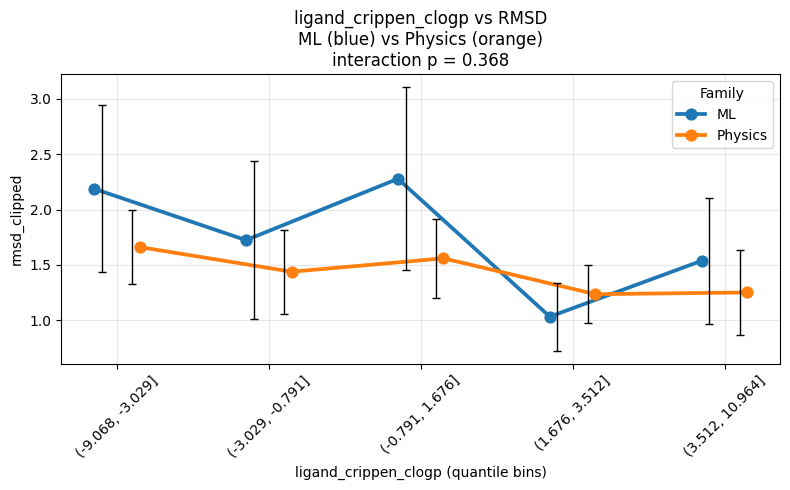

0.36765595278883917
                                                 Mixed Linear Model Regression Results
Model:                                      MixedLM                           Dependent Variable:                           rmsd_clipped
No. Observations:                           907                               Method:                                       REML        
No. Groups:                                 460                               Scale:                                        5.7156      
Min. group size:                            1                                 Log-Likelihood:                               -2143.9187  
Max. group size:                            2                                 Converged:                                    Yes         
Mean group size:                            2.0                                                                                         
-----------------------------------------------------------------------

In [25]:
results = property_analysis.analyze_continous_property_mixed_effects(
    df_combined[df_combined["method"].isin(["chai-1", "diffdock_pocket_only", "surfdock"])],
    df_combined[df_combined["method"].isin(["icm", "vina"])],
    property_name=property, 
    group1_label="ML",
    group2_label="Physics",
)
print(results['p_interaction'])
print(results['model_full'].summary())
print(results['model_noint'].summary())

### ligand_num_interactions

(12153, 4)
                          Mixed Linear Model Regression Results
Model:                        MixedLM           Dependent Variable:           rmsd       
No. Observations:             12153             Method:                       REML       
No. Groups:                   460               Scale:                        117.6839   
Min. group size:              10                Log-Likelihood:               -46621.5840
Max. group size:              35                Converged:                    Yes        
Mean group size:              26.4                                                       
-----------------------------------------------------------------------------------------
                                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------
Intercept                                       9.033    0.625 14.441 0.000  7.807 10.259
Method_Type[T.Physics]   

/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/plinder_analysis_utils.py:4188: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(


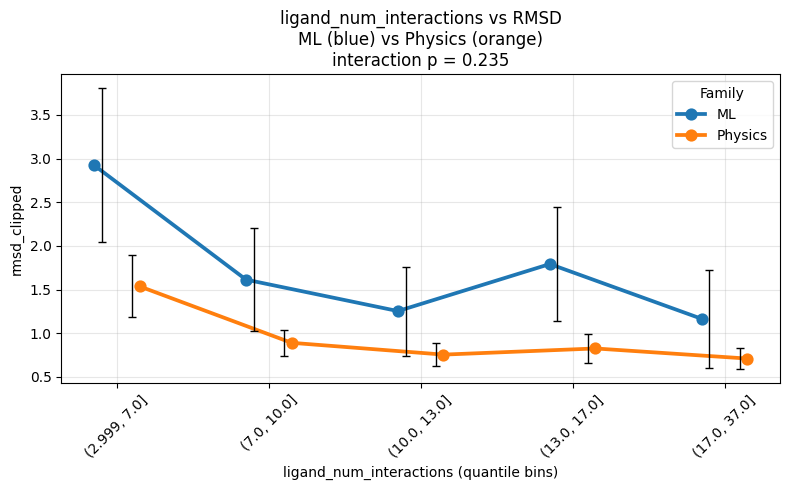

p_interaction: 0.23459881575781846
                                                 Mixed Linear Model Regression Results
Model:                                       MixedLM                          Dependent Variable:                          rmsd_clipped
No. Observations:                            917                              Method:                                      REML        
No. Groups:                                  460                              Scale:                                       4.8751      
Min. group size:                             1                                Log-Likelihood:                              -2092.7752  
Max. group size:                             2                                Converged:                                   Yes         
Mean group size:                             2.0                                                                                       
--------------------------------------------------------------

In [30]:
property = "ligand_num_interactions"
df_method = (
    df_mixed[[
        "rmsd",
        property,
        "Method_Type",
        "protein"       # or "system_id", whichever you’re grouping by
    ]]
    .dropna()
    .reset_index(drop=True)    # <<-- important!
)
print(df_method.shape)

property_analysis.analyze_comparative_fixed_effects(df_method, property, "Method_Type", "rmsd", "protein")

results = property_analysis.analyze_continous_property_mixed_effects(
    df_combined[df_combined["method"].isin(["chai-1", "diffdock_pocket_only", "surfdock"])],
    df_combined[df_combined["method"].isin(["icm", "gnina", "vina"])],
    property_name=property, 
    group1_label="ML",
    group2_label="Physics",
)
print(f"p_interaction: {results['p_interaction']}")
print(results['model_full'].summary())
print(results['model_noint'].summary())


#### without gnina

/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/plinder_analysis_utils.py:4188: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(


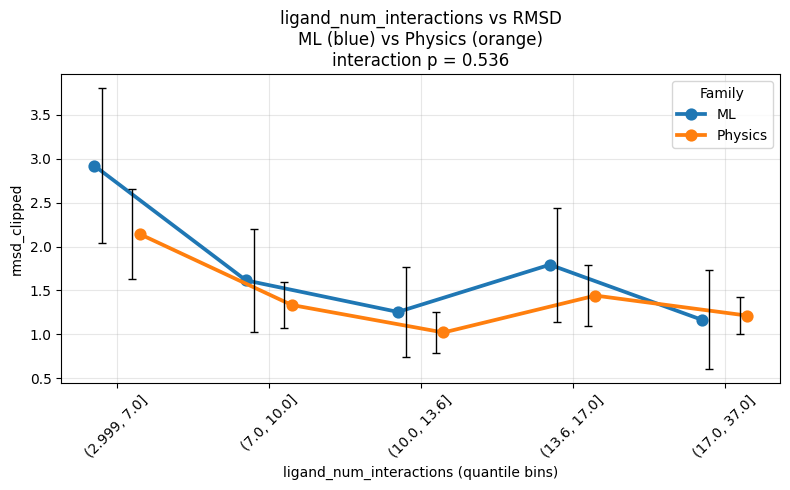

0.5363647926741059
                                                 Mixed Linear Model Regression Results
Model:                                       MixedLM                          Dependent Variable:                          rmsd_clipped
No. Observations:                            907                              Method:                                      REML        
No. Groups:                                  460                              Scale:                                       5.7010      
Min. group size:                             1                                Log-Likelihood:                              -2134.2425  
Max. group size:                             2                                Converged:                                   Yes         
Mean group size:                             2.0                                                                                       
------------------------------------------------------------------------------

In [31]:
results = property_analysis.analyze_continous_property_mixed_effects(
    df_combined[df_combined["method"].isin(["chai-1", "diffdock_pocket_only", "surfdock"])],
    df_combined[df_combined["method"].isin(["icm", "vina"])],
    property_name=property, 
    group1_label="ML",
    group2_label="Physics",
)
print(results['p_interaction'])
print(results['model_full'].summary())
print(results['model_noint'].summary())

### ligand_num_neighboring_residues

### ligand_num_interacting_residues

In [ ]:
df_mixed = (
    df_mixed[[
        "rmsd",
        "ligand_num_interacting_residues",
        "Method_Type",
        "protein"       # or "system_id", whichever you’re grouping by
    ]]
    .dropna()
    .reset_index(drop=True)    # <<-- important!
)
df_mixed.shape

(12153, 4)

## GAM

### A Test Case for Mixed Effect Analysis, GAM, and Batch Testing

#### 1. Mixed-Effects Linear Model (per-property)

In [ ]:
import statsmodels.formula.api as smf

model = smf.mixedlm(
    "rmsd ~ ligand_num_interacting_residues * Method_Type",
    data=df_mixed,
    groups=df_mixed["protein"]
).fit()

print(model.summary())

                        Mixed Linear Model Regression Results
Model:                       MixedLM          Dependent Variable:          rmsd       
No. Observations:            12163            Method:                      REML       
No. Groups:                  462              Scale:                       117.5639   
Min. group size:             5                Log-Likelihood:              -46651.8153
Max. group size:             35               Converged:                   Yes        
Mean group size:             26.3                                                     
--------------------------------------------------------------------------------------
                                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------
Intercept                                    6.599    0.440 14.997 0.000  5.737  7.462
Method_Type[T.Physics]                      -1.770    0.345 -5.135 0

#### 2. Generalized Additive Model (to capture non-linearity)

In [ ]:
import numpy as np
from pygam import LinearGAM, s, f

# Encode Method_Type as 0 (Physics) / 1 (ML)
df = df_mixed.copy()
df["Method_Num"] = (df["Method_Type"] == "ML").astype(int)

X = df[["ligand_num_hba", "Method_Num"]].values
y = df["rmsd"].values

# s(0) is a spline on ligand_num_hba
# f(1) is a factor for Method_Num
# s(0, by=1) is an interaction spline (separate smooths per Method_Num)
gam = LinearGAM(s(0) + f(1) + s(0, by=1)).fit(X, y)

gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     31.1607
Link Function:                     IdentityLink Log Likelihood:                                -70827.4094
Number of Samples:                        12153 AIC:                                           141719.1403
                                                AICc:                                          141719.3163
                                                GCV:                                              135.6353
                                                Scale:                                            135.0095
                                                Pseudo R-Squared:                                   0.0297
Feature Function                  Lam

/var/folders/bb/dyy85zps4_lg79d6g6g48ms00000gn/T/ipykernel_29490/2918155216.py:16: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


#### 3. Batch Testing + FDR Correction (multiple properties)

In [ ]:
from statsmodels.stats.multitest import multipletests
import statsmodels.formula.api as smf

properties = [
    'ligand_num_hba',
    'ligand_num_hbd',
    'ligand_molecular_weight',
    # … add more
]

results = []
for prop in properties:
    formula = f"rmsd ~ {prop} * Method_Type"
    m = smf.mixedlm(formula, data=df_mixed, groups=df_mixed["protein"]).fit()
    p_int = m.pvalues.get(f"{prop}:Method_Type[T.ML]", np.nan)
    results.append((prop, p_int))

# Pull out p-values and correct
props, pvals = zip(*results)
rejected, pvals_corrected, _, _ = multipletests(pvals, method="fdr_bh")

for prop, p_un, p_cor, rej in zip(props, pvals, pvals_corrected, rejected):
    print(f"{prop:20s}  p_int={p_un:.3g}  p_fdr={p_cor:.3g}  significant={rej}")

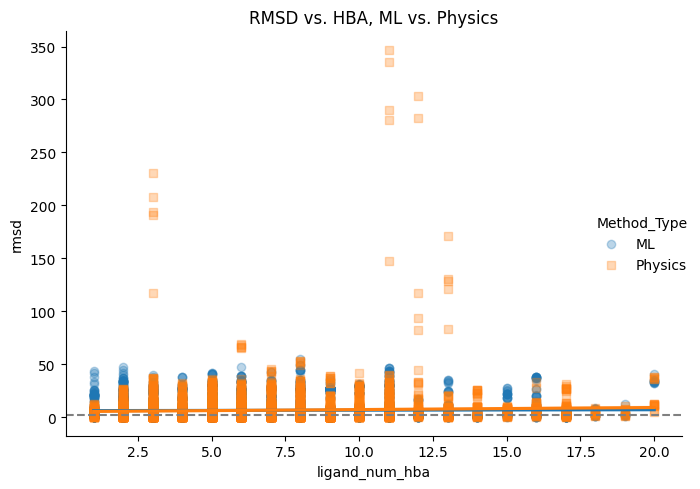

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lmplot(
    data=df_mixed,
    x="ligand_num_hba",
    y="rmsd",
    hue="Method_Type",
    scatter_kws={'alpha':0.3},
    height=5, aspect=1.2,
    markers=["o","s"]
)
plt.axhline(2.0, color='grey', linestyle='--', label="RMSD=2Å")
plt.title("RMSD vs. HBA, ML vs. Physics")
plt.tight_layout()
plt.show()

In [ ]:
# e.g. low (≤5), medium (6–10), high (>10) HBA
df_mixed['HBA_bin'] = pd.cut(df_mixed['ligand_num_hba'],
                                bins=[0,5,10,df_mixed.ligand_num_hba.max()],
                                labels=['low','med','high'])
summary = (
    df_mixed
    .assign(success=lambda d: d.rmsd < 2.0)
    .groupby(['HBA_bin','Method_Type'])
    .success
    .agg(['mean','count'])
    .rename(columns={'mean':'success_rate','count':'n'})
    .reset_index()
)
print(summary)

  HBA_bin Method_Type  success_rate     n
0     low          ML      0.518182  2640
1     low     Physics      0.238710  2325
2     med          ML      0.516879  2666
3     med     Physics      0.262417  2557
4    high          ML      0.454167   960
5    high     Physics      0.207960  1005
